In [1]:
import pandas as pd

food_orders = pd.read_csv("food_orders_new_delhi.csv")
food_orders.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [2]:
print(food_orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB
None


In [3]:
from datetime import datetime

# convert date and time columns to datetime
food_orders['Order Date and Time'] = pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] = pd.to_datetime(food_orders['Delivery Date and Time'])

In [4]:
food_orders['Discounts and Offers'] = food_orders['Discounts and Offers'].astype(str)

In [5]:
# Function to extract numeric values from the 'Discounts and Offers' string
def extract_discount(discount_str):
    if 'off' in discount_str:
        if '%' in discount_str:
            # Percentage off
            return float(discount_str.split('%')[0])
        else:
            # Fixed amount off
            return float(discount_str.split(' ')[0])
    else:
        # No discount
        return 0.0

In [6]:
# apply the function to create a new 'Discount Value' column
food_orders['Discount Percentage'] = food_orders['Discounts and Offers'].apply(lambda x: extract_discount(x))

In [7]:
# for percentage discounts, calculate the discount amount based on the order value
food_orders['Discount Amount'] = food_orders.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)

In [8]:
# adjust 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column
food_orders['Discount Amount'] = food_orders.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)

In [9]:
print(food_orders[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head(), food_orders.dtypes)

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  0.0              0.0
1          986                  10%                  0.0              0.0
2          937         15% New User                  0.0              0.0
3         1463                  nan                  0.0              0.0
4         1992         50 off Promo                 50.0            996.0 Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount        

In [10]:
# calculate total costs and revenue per order
food_orders['Total Costs'] = food_orders['Delivery Fee'] + food_orders['Payment Processing Fee'] + food_orders['Discount Amount']
food_orders['Revenue'] = food_orders['Commission Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

In [13]:
# aggregate data to get overall metrics
total_orders = food_orders.shape[0]
total_orders

1000

In [14]:
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

In [16]:
overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

overall_metrics

{'Total Orders': 1000,
 'Total Revenue': 126990,
 'Total Costs': 168470.0,
 'Total Profit': -41480.0}

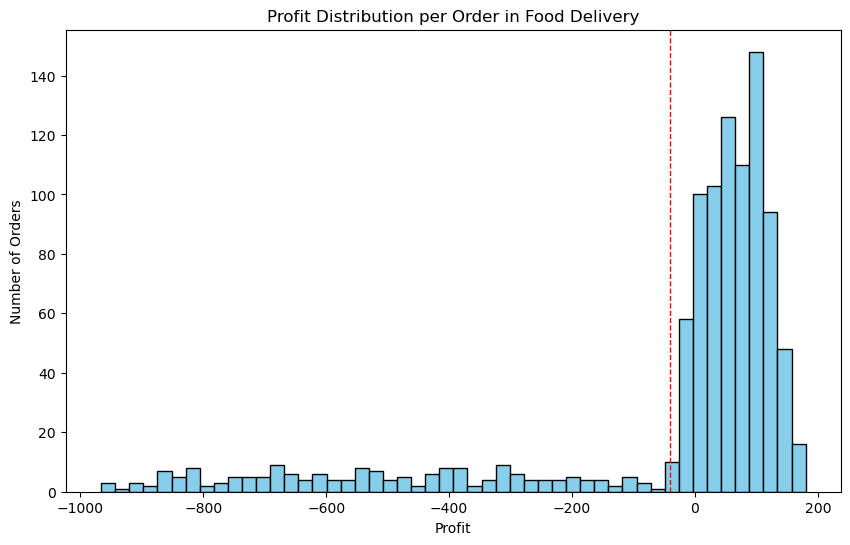

In [17]:
import matplotlib.pyplot as plt

# histogram of profits per order
plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

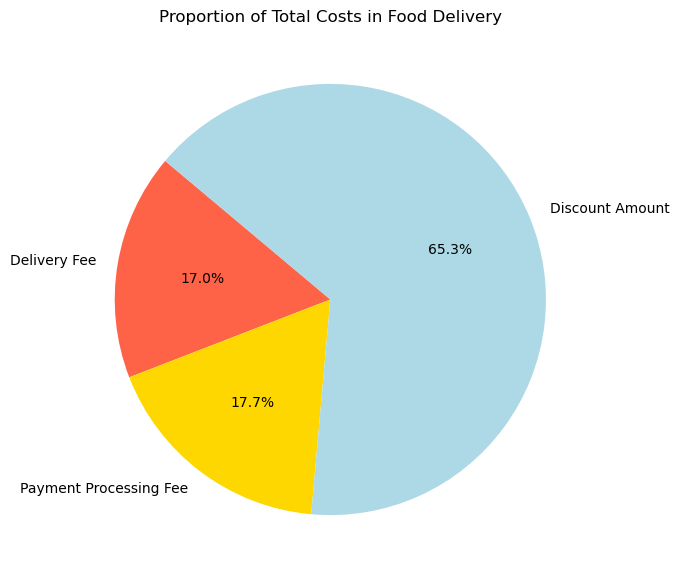

In [19]:
# pie chart for the proportion of total costs
costs_breakdown = food_orders[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

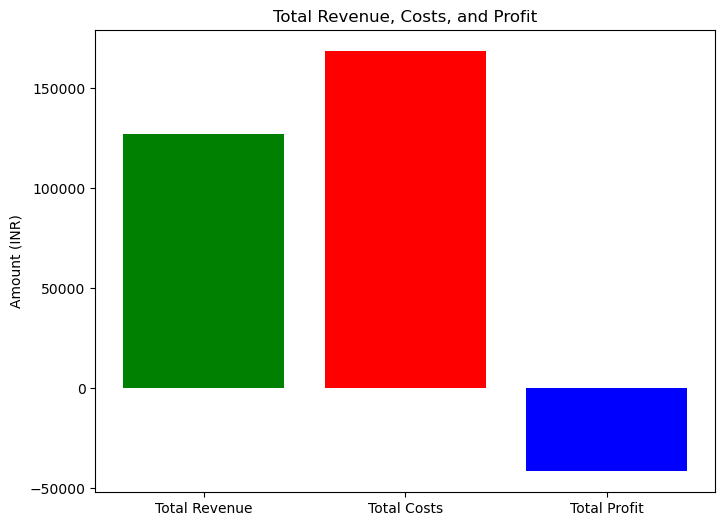

In [20]:
# bar chart for total revenue, costs, and profit
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show()

In [26]:
# filter the dataset for profitable orders
profitable_orders = food_orders[food_orders['Profit'] > 0]

In [28]:
# calculate the average commission percentage for profitable orders
profitable_orders.loc[:, 'Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

In [30]:
# calculate the average discount percentage for profitable orders
profitable_orders.loc[:, 'Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

In [31]:
# calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()

print(new_avg_commission_percentage, new_avg_discount_percentage)

21.94089361259831 0.5427408412483039


In [34]:
# simulate profitability with recommended discounts and commissions
recommended_commission_percentage = 22.0  # 22%
recommended_discount_percentage = 0.5    # 0.5%

# calculate the simulated commission fee and discount amount using recommended percentages
food_orders['Simulated Commission Fee'] = food_orders['Order Value'] * (recommended_commission_percentage / 100)
food_orders['Simulated Discount Amount'] = food_orders['Order Value'] * (recommended_discount_percentage / 100)

# recalculate total costs and profit with simulated values
food_orders['Simulated Total Costs'] = (food_orders['Delivery Fee'] +
                                        food_orders['Payment Processing Fee'] +
                                        food_orders['Simulated Discount Amount'])

food_orders['Simulated Profit'] = (food_orders['Simulated Commission Fee'] -
                                   food_orders['Simulated Total Costs'])

C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


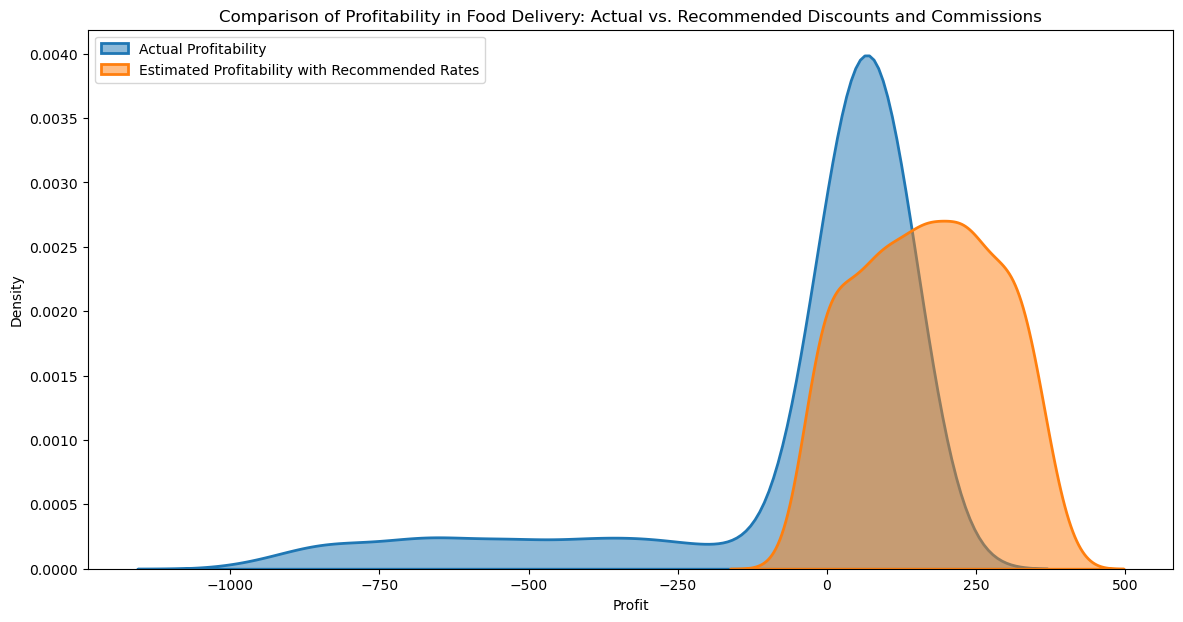

In [35]:
# visualizing the comparison
import seaborn as sns

plt.figure(figsize=(14, 7))

# actual profitability
sns.kdeplot(food_orders['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# simulated profitability
sns.kdeplot(food_orders['Simulated Profit'], label='Estimated Profitability with Recommended Rates', fill=True, alpha=0.5, linewidth=2)

plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()